In [ ]:
!pip install torch==1.11.0  # version recommended by source

In [ ]:
!pip install git+https://github.com/gretelai/gretel-synthetics.git

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
from skimage.util.shape import view_as_windows

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [4]:
# https://www.kaggle.com/code/xiaxiaxu/predictmachinefailureinadvance/data
sensor = pd.read_csv("sensor.csv")

# data columns
COLS = ["sensor_25", "sensor_11", "sensor_36", "sensor_34", "machine_status"]

# only keeping cols w high var in pca analysis + machine status
data = sensor[["timestamp"] + COLS]
data

,timestamp,sensor_25,sensor_11,sensor_36,sensor_34,machine_status
0,2018-04-01 00:00:00,741.7151,47.52422,195.0655,171.9375,NORMAL
1,2018-04-01 00:01:00,741.7151,47.52422,195.0655,171.9375,NORMAL
2,2018-04-01 00:02:00,740.8031,48.17723,200.9694,169.9820,NORMAL
3,2018-04-01 00:03:00,739.2722,48.65607,193.1689,166.4987,NORMAL
4,2018-04-01 00:04:00,737.6033,49.06298,193.8770,164.7498,NORMAL
...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,700.5885,54.16052,817.5707,266.0334,NORMAL
220316,2018-08-31 23:56:00,698.4915,54.52602,807.0151,262.2222,NORMAL
220317,2018-08-31 23:57:00,703.1645,55.11779,805.5605,260.8372,NORMAL
220318,2018-08-31 23:58:00,697.3713,55.99321,807.0808,261.3184,NORMAL


In [5]:
# lets convert our datatypes to the correct ones

print(data.dtypes, "\n")
# i have no idea why i have to run this line twice for it to work.
data["timestamp"] = pd.to_datetime(data["timestamp"])

timestamp          object
sensor_25         float64
sensor_11         float64
sensor_36         float64
sensor_34         float64
machine_status     object
dtype: object 



/tmp/ipykernel_280/3253553817.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamp']= pd.to_datetime(data['timestamp'])


In [6]:
# okay, what can our machine status be?

# data = data.convert_dtypes()
print(data.dtypes, "\n")
# i have no idea why i have to run this line twice for it to work.
data["timestamp"] = pd.to_datetime(data["timestamp"])

data.machine_status.unique()

timestamp         datetime64[ns]
sensor_25                float64
sensor_11                float64
sensor_36                float64
sensor_34                float64
machine_status            object
dtype: object 



/tmp/ipykernel_280/2577753386.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamp']= pd.to_datetime(data['timestamp'])


array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

In [7]:
# lets drop the NaNs

data.dropna(axis=0, inplace=True)

print(len(data[data.isna().any(axis=1)]))

0


/tmp/ipykernel_280/1392926604.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(axis=0, inplace=True)


In [8]:
# lets try only using data centered around 2 failures.

data_around_failures = data.iloc[16000:26080]
print(len(data_around_failures))
data_around_failures

10080


,timestamp,sensor_25,sensor_11,sensor_36,sensor_34,machine_status
16000,2018-04-12 02:40:00,649.0801,49.93274,299.4172,160.6844,NORMAL
16001,2018-04-12 02:41:00,651.8054,51.08754,296.3760,162.5435,NORMAL
16002,2018-04-12 02:42:00,650.1391,51.24662,305.7853,164.4021,NORMAL
16003,2018-04-12 02:43:00,649.2632,51.93151,294.0909,166.5538,NORMAL
16004,2018-04-12 02:44:00,643.1567,51.71158,298.7494,168.0882,NORMAL
...,...,...,...,...,...,...
26076,2018-04-19 02:36:00,650.5313,0.00000,299.8132,177.0259,RECOVERING
26077,2018-04-19 02:37:00,648.3717,0.00000,300.4203,178.1746,RECOVERING
26078,2018-04-19 02:38:00,648.1866,0.00000,298.3055,179.5653,RECOVERING
26079,2018-04-19 02:39:00,650.0446,0.00000,297.7022,181.8661,RECOVERING


In [14]:
# # let's now scale our data between 0-1

# scaler = MinMaxScaler((0,1))
sensor_cols = ["sensor_25", "sensor_11", "sensor_36", "sensor_34"]

# # scaling our data, then saving our scaler object for future use.
# data_around_failures[sensor_cols] = scaler.fit_transform(data_around_failures[sensor_cols])

# dump(scaler, open('dGAN_scaler_windowing.pkl', 'wb'))

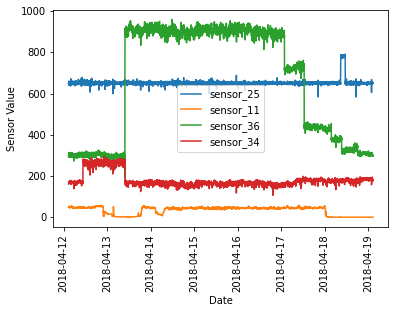

In [15]:
# Plot the 4 scaled sensors

for c in COLS:
    if c == "machine_status":
        continue
    plt.plot(data_around_failures["timestamp"], data_around_failures[c], label=c)

plt.xticks(rotation=90)
plt.legend()
plt.ylabel("Sensor Value")
plt.xlabel("Date")
plt.show()

In [16]:
# dropping timestamp col
features = data_around_failures.drop(columns=["timestamp", "machine_status"]).to_numpy()
print(features.shape)

(10080, 4)


In [24]:
window_shape = (240, 4)
windowed_data = view_as_windows(features, window_shape, step=10)
windowed_data = np.squeeze(windowed_data)
print(windowed_data.shape)
print(windowed_data[0].shape)
windowed_data.shape

(985, 240, 4)
(240, 4)


(985, 240, 4)

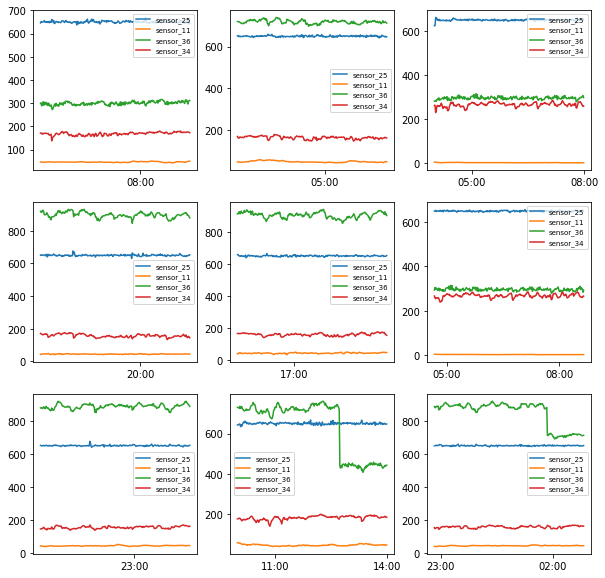

In [18]:
# Show a few of the 4-hour training samples
# note x-axis isnt accurate in these plots.
# xaxis_4hr = data_around_failures["timestamp"][0:240]


def plot_hours(f, ind):
    # get the 4hr time period of these points - might be wrong
    # but i think the logic is right.
    xaxis_4hr = data_around_failures["timestamp"][ind * 10 : ind * 10 + 240]

    for i, c in enumerate(sensor_cols):
        plt.plot(xaxis_4hr, f[:, i], label=c)
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(byhour=range(2, 24, 3)))
    ax.xaxis.set_major_formatter(md.DateFormatter("%H:%M"))
    plt.legend(prop={"size": 7})


figure = plt.figure(figsize=(10, 10))
for i in range(1, 10):
    sample_idx = torch.randint(len(windowed_data), size=(1,)).item()
    point = windowed_data[sample_idx]
    figure.add_subplot(3, 3, i)

    plot_hours(point, sample_idx)
plt.show()

In [19]:
# Recommended to train with a GPU
torch.cuda.is_available()

True

In [25]:
# set up DGAN config.

config = DGANConfig(
    max_sequence_len=windowed_data.shape[1],
    sample_len=20,  # trying a larger sample_len
    batch_size=min(1000, windowed_data.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
)

model = DGAN(config)

In [27]:
model.train_numpy(
    windowed_data,
    feature_types=[OutputType.CONTINUOUS] * windowed_data.shape[2],
)
# this took 7 minutes on Small + GPU

2022-07-13 14:53:00,138 : MainThread : INFO : epoch: 0
2022-07-13 14:53:00,344 : MainThread : INFO : epoch: 1
2022-07-13 14:53:00,435 : MainThread : INFO : epoch: 2
2022-07-13 14:53:00,510 : MainThread : INFO : epoch: 3
2022-07-13 14:53:00,579 : MainThread : INFO : epoch: 4
2022-07-13 14:53:00,645 : MainThread : INFO : epoch: 5
2022-07-13 14:53:00,714 : MainThread : INFO : epoch: 6
2022-07-13 14:53:00,784 : MainThread : INFO : epoch: 7
2022-07-13 14:53:00,848 : MainThread : INFO : epoch: 8
2022-07-13 14:53:00,911 : MainThread : INFO : epoch: 9
2022-07-13 14:53:00,973 : MainThread : INFO : epoch: 10
2022-07-13 14:53:01,041 : MainThread : INFO : epoch: 11
2022-07-13 14:53:01,105 : MainThread : INFO : epoch: 12
2022-07-13 14:53:01,169 : MainThread : INFO : epoch: 13
2022-07-13 14:53:01,232 : MainThread : INFO : epoch: 14
2022-07-13 14:53:01,295 : MainThread : INFO : epoch: 15
2022-07-13 14:53:01,358 : MainThread : INFO : epoch: 16
2022-07-13 14:53:01,564 : MainThread : INFO : epoch: 17
20

In [39]:
# Generate synthetic data - this ran near instantly
_, synthetic_features = model.generate_numpy(1000)

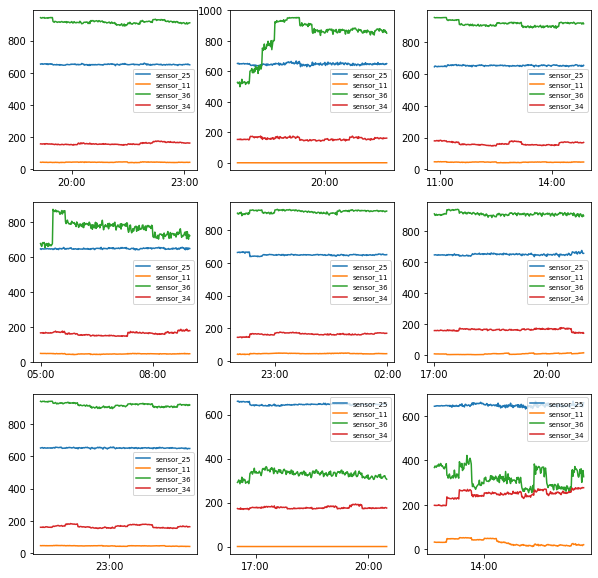

In [40]:
# plot windowed data - the x-axis in these plots is meaningless here

figure = plt.figure(figsize=(10, 10))
for i in range(1, 10):
    sample_idx = torch.randint(len(synthetic_features), size=(1,)).item()
    point = synthetic_features[sample_idx]
    figure.add_subplot(3, 3, i)

    plot_hours(point, sample_idx)
plt.show()

In [41]:
# Compare (non-temporal) correlations between the 4 sensors
synthetic_df = pd.DataFrame(
    synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=sensor_cols
)

print("Correlation in real data:")
print(data_around_failures.drop(columns=["timestamp", "machine_status"]).corr())
print()
print("Correlation in synthetic data:")
print(synthetic_df.corr())

# Correlations between sensor variables are even more similar

Correlation in real data:
           sensor_25  sensor_11  sensor_36  sensor_34
sensor_25   1.000000  -0.197810  -0.145523  -0.022030
sensor_11  -0.197810   1.000000   0.402658  -0.180775
sensor_36  -0.145523   0.402658   1.000000  -0.632188
sensor_34  -0.022030  -0.180775  -0.632188   1.000000

Correlation in synthetic data:
           sensor_25  sensor_11  sensor_36  sensor_34
sensor_25   1.000000  -0.060652  -0.067732  -0.017192
sensor_11  -0.060652   1.000000   0.379241  -0.163648
sensor_36  -0.067732   0.379241   1.000000  -0.668191
sensor_34  -0.017192  -0.163648  -0.668191   1.000000


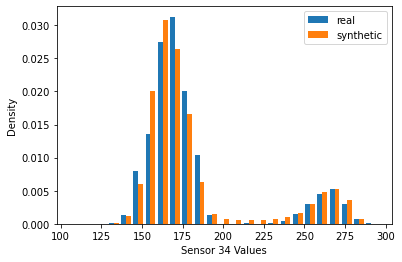

In [42]:
# Compare distribution of sensor_34 values
plt.hist(
    [windowed_data[:, :, 3].flatten(), synthetic_features[:, :, 3].flatten()],
    label=["real", "synthetic"],
    bins=25,
    density=True,
)
plt.legend()
plt.xlabel("Sensor 34 Values")
plt.ylabel("Density")
plt.show()

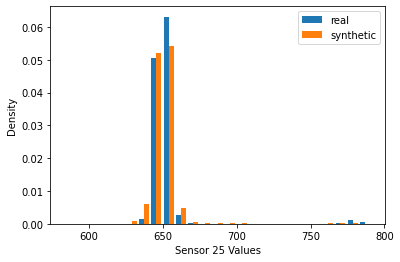

In [43]:
# Compare distribution of sensor_25 values
plt.hist(
    [windowed_data[:, :, 0].flatten(), synthetic_features[:, :, 0].flatten()],
    label=["real", "synthetic"],
    bins=25,
    density=True,
)
plt.legend()
plt.xlabel("Sensor 25 Values")
plt.ylabel("Density")
plt.show()

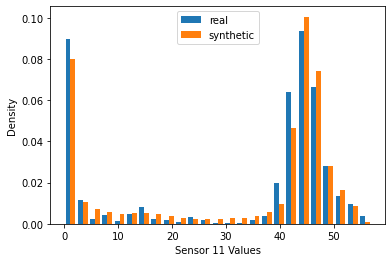

In [44]:
# Compare distribution of sensor_11 values
plt.hist(
    [windowed_data[:, :, 1].flatten(), synthetic_features[:, :, 1].flatten()],
    label=["real", "synthetic"],
    bins=25,
    density=True,
)
plt.legend()
plt.xlabel("Sensor 11 Values")
plt.ylabel("Density")
plt.show()

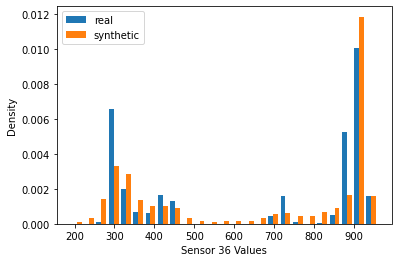

In [45]:
# Compare distribution of sensor_36 values
plt.hist(
    [windowed_data[:, :, 2].flatten(), synthetic_features[:, :, 2].flatten()],
    label=["real", "synthetic"],
    bins=25,
    density=True,
)
plt.legend()
plt.xlabel("Sensor 36 Values")
plt.ylabel("Density")
plt.show()

In [46]:
# saving model for future use
model.save("../models/dgan_model_1.pt")

# X = model.load("dgan_model_0.pt")

# X